# Project Inquiries:

1) Is the Earth’s temperature rising over time?

2) Does Earth’s temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import fbprophet

import wrangle
import explore
import modeling



import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

In [3]:
df_land, df_ocean = wrangle.pre_split_prep()

### Split into train using ~80% train, ~13% validate, and ~7% test, seperating data at the end of the nearest year

In [4]:
train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean = wrangle.tvt_split(df_land, df_ocean)

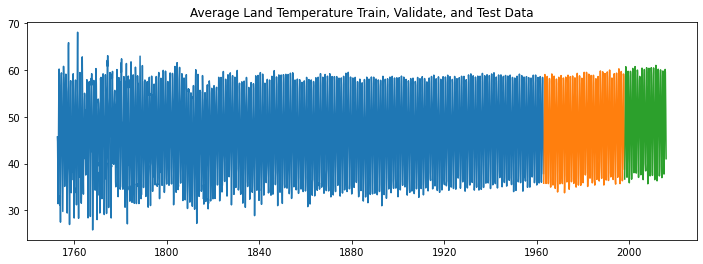

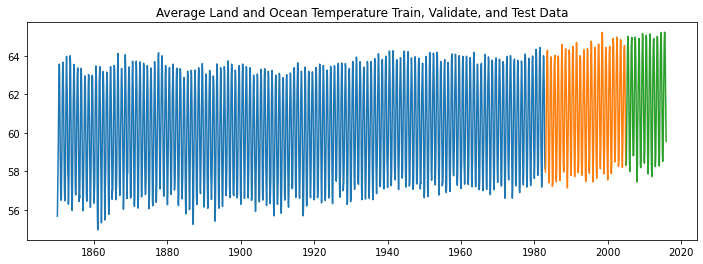

In [5]:
wrangle.show_split(train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean)

# Explore

View each temperature line next to the other, resample using the average temperature by year, and by decade.

In [6]:
train_land.describe()

,LandAverageTemperature
count,2523.000000
mean,46.412162
std,8.833361
min,25.840000
25%,38.162000
50%,46.832000
75%,54.654000
max,68.042000


In [7]:
train_ocean.describe()

,LandAndOceanAverageTemperature
count,1596.000000
mean,60.196054
std,2.517954
min,54.950000
25%,57.828000
50%,60.318000
75%,62.582000
max,64.434000


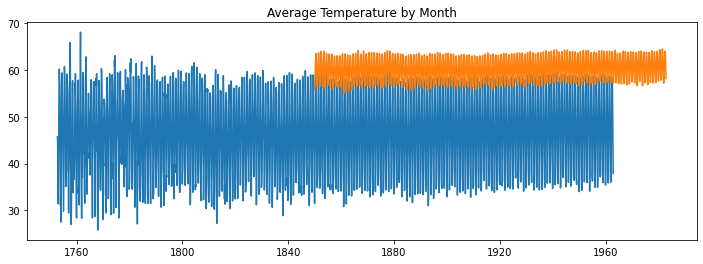

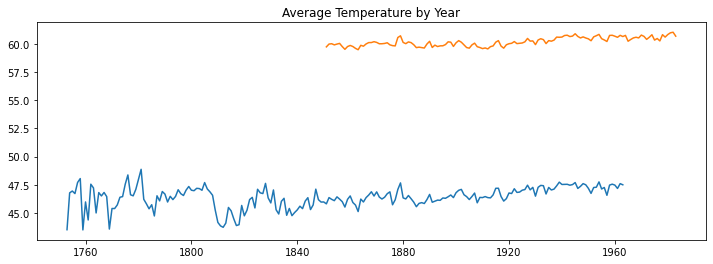

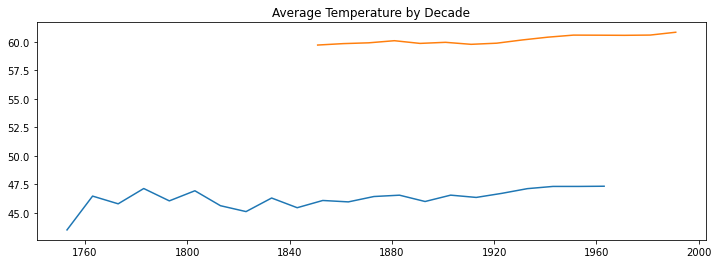

In [8]:
explore.show_explore(train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean)

LandAverageTemperature 



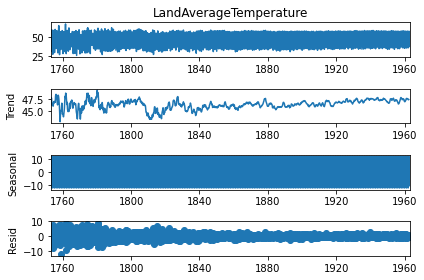

LandAndOceanAverageTemperature 



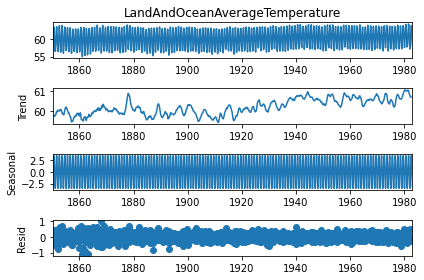

In [9]:
explore.show_sesonal_decomp(train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean)

# Modeling

### Make predictions using last observed value

In [22]:
eval_df_land = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df_ocean = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

LandAverageTemperature -- RMSE: 12.8058


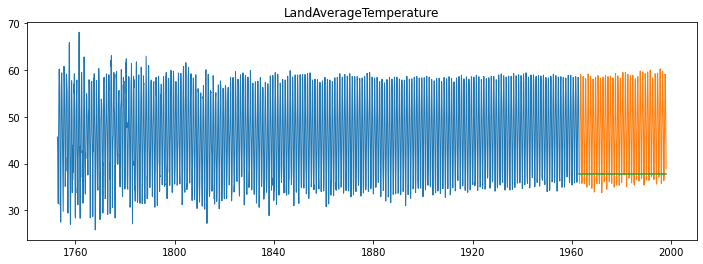

In [21]:
eval_df_land = modeling.last_observed_value(train_land, validate_land, test_land, 'LandAverageTemperature', eval_df_land)

LandAndOceanAverageTemperature -- RMSE: 3.8887


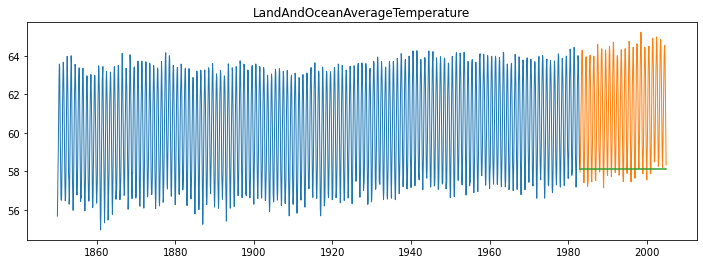

In [20]:
eval_df_ocean = modeling.last_observed_value(train_ocean, validate_ocean, test_ocean, 'LandAndOceanAverageTemperature', eval_df_ocean)

### Make predictions using simple average

In [ ]:
temps = round(train_land['LandAverageTemperature'].mean(),2)

yhat_land_df = pd.DataFrame({'LandAverageTemperature': [temps]}, index = validate_land.index)

yhat_land_df.head(2)

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
eval_df_land = append_eval_df_land('Simple Average', 'LandAverageTemperature')
eval_df_land

In [ ]:
temps = round(train_ocean['LandAndOceanAverageTemperature'].mean(),2)

yhat_ocean_df = pd.DataFrame({'LandAndOceanAverageTemperature': [temps]}, index = validate_ocean.index)

yhat_ocean_df.head(2)

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')

In [ ]:
eval_df_ocean = append_eval_df_ocean('Simple Average', 'LandAndOceanAverageTemperature')
eval_df_ocean

### Make predictions based on moving average for month, year, and decade.

In [ ]:
for period in [1,12,120]:

    temps = round(train_land['LandAverageTemperature'].rolling(period).mean().iloc[-1],2)

    yhat_land_df = pd.DataFrame({'LandAverageTemperature': [temps]}, index = validate_land.index)
    
    print(plot_and_eval_land('LandAverageTemperature'))
    
    eval_df_land = append_eval_df_land(f'{period}Month Moving Average', 'LandAverageTemperature')

In [ ]:
eval_df_land

In [ ]:
for period in [1,12,120]:

    temps = round(train_ocean['LandAndOceanAverageTemperature'].rolling(period).mean().iloc[-1],2)

    yhat_ocean_df = pd.DataFrame({'LandAndOceanAverageTemperature': [temps]}, index = validate_ocean.index)
    
    print(plot_and_eval_ocean('LandAndOceanAverageTemperature'))
    
    eval_df_ocean = append_eval_df_ocean(f'{period}Month Moving Average', 'LandAndOceanAverageTemperature')

In [ ]:
eval_df_ocean

### Make predictions using Holt's Linear Trend

In [ ]:
model = Holt(train_land['LandAverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate_land.index[0], 
                           end = validate_land.index[-1])
yhat_land_df['LandAverageTemperature'] = round(yhat_items, 2)

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
model = Holt(train_ocean['LandAndOceanAverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate_ocean.index[0], 
                           end = validate_ocean.index[-1])
yhat_ocean_df['LandAndOceanAverageTemperature'] = round(yhat_items, 2)

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')

### Make Predictions using previous cycle

In [ ]:
train_land = df_land[:'1996'].copy()
train_cycle_land = df_land['1996'].copy()
validate_land = df_land['1997'].copy()

In [ ]:
yhat_land_df = train_cycle_land + train_land.diff(365).mean()

In [ ]:
yhat_land_df.index = validate_land.index

In [ ]:
plot_and_eval_land('LandAverageTemperature')
eval_df_land = append_eval_df_land('Previous Cycle', 'LandAverageTemperature')

In [ ]:
train_ocean = df_lo[:'2003']
train_ocean_cycle = df_lo['2003']
validate_ocean = df_lo['2004']

yhat_ocean_df = train_ocean_cycle + train_ocean.diff(365).mean()

yhat_ocean_df.index = validate_ocean.index

plot_and_eval_ocean('LandAndOceanAverageTemperature')

### Make predictions using the Holt-Winter method

In [ ]:
train_land = df_land[:'1962-12-01'] 
validate_land = df_land['1963-01-01':'1997-12-01']
test_land = df_land['1998-01-01':]

train_ocean = df_lo[:'1982-12-01']
validate_ocean = df_lo['1983-01-01':'2004-12-01']
test_ocean = df_lo['2005-01-01':]

In [ ]:
model = ExponentialSmoothing(np.asarray(train_land['LandAverageTemperature']) ,seasonal_periods=12 ,trend='add', seasonal='add',)

model = model.fit()

yhat_items = model.forecast(len(yhat_land_df))

yhat_land_df['LandAverageTemperature'] = yhat_items

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
model = ExponentialSmoothing(np.asarray(train_ocean['LandAndOceanAverageTemperature']) ,seasonal_periods=12 ,trend='add', seasonal='add',)

model = model.fit()

yhat_items = model.forecast(len(yhat_ocean_df))

yhat_ocean_df['LandAndOceanAverageTemperature'] = yhat_items

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')